In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt

import IPython

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

1.12.1
0.12.1


In [2]:
symbols = '_-!\'(),.:;? abcdefghijklmnopqrstuvwxyz'
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)

def text_to_sequence(text):
  text = text.lower()
  return [look_up[s] for s in text if s in symbols]

text = "Hello world! Text to speech!"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]


In [3]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "Hello world! Text to speech!"
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 31, 16, 35, 31, 11,
         31, 26, 11, 30, 27, 16, 16, 14, 19,  2]])
tensor([28], dtype=torch.int32)


In [4]:
print([processor.tokens[i] for i in processed[0, :lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


Phoneme-based encoding is similar to character-based encoding, but it uses a symbol table based on phonemes and a G2P (Grapheme-to-Phoneme) model.

The following code illustrates how to make and use the process. Behind the scene, a G2P model is created using DeepPhonemizer package, and the pretrained weights published by the author of DeepPhonemizer is fetched.



In [5]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "Hello world! Text to speech!"
with torch.inference_mode():
  processed, lengths = processor(text)

print(processed)
print(lengths)

  0%|          | 0.00/63.6M [00:00<?, ?B/s]

tensor([[54, 20, 65, 69, 11, 92, 44, 65, 38,  2, 11, 81, 40, 64, 79, 81, 11, 81,
         20, 11, 79, 77, 59, 37,  2]])
tensor([25], dtype=torch.int32)


In [6]:
print([processor.tokens[i] for i in processed[0, :lengths[0]]])

['HH', 'AH', 'L', 'OW', ' ', 'W', 'ER', 'L', 'D', '!', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH', '!']


Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth" to /Users/fischer/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth


  0%|          | 0.00/107M [00:00<?, ?B/s]

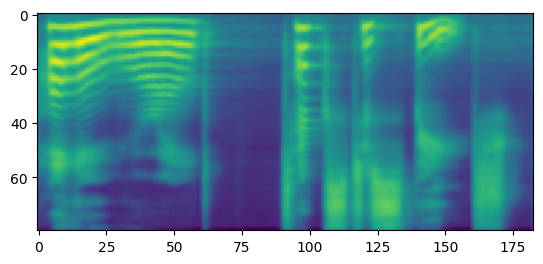

In [7]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
  processed, lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, _, _ = tacotron2.infer(processed, lengths)


plt.imshow(spec[0].cpu().detach())

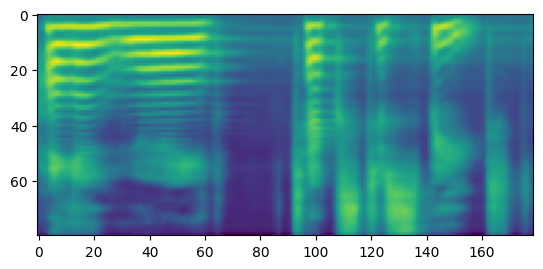

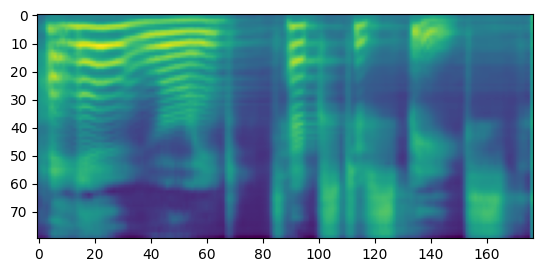

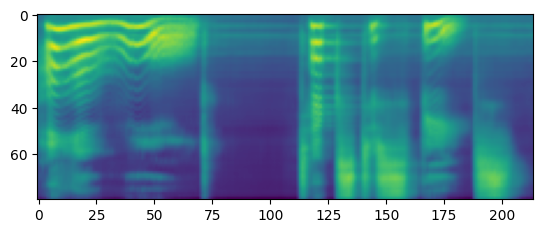

In [8]:
for _ in range(3):
  with torch.inference_mode():
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
  plt.imshow(spec[0].cpu().detach())
  plt.show()

In [9]:
# Once the spectrogram is generated, the last process is to recover the 
# waveform from the spectrogram.

bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
  processed, lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
  waveforms, lengths = vocoder(spec, spec_lengths)

torchaudio.save("data/output_wavernn.wav", waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)
IPython.display.display(IPython.display.Audio("output_wavernn.wav"))

Downloading: "https://download.pytorch.org/torchaudio/models/wavernn_10k_epochs_8bits_ljspeech.pth" to /Users/fischer/.cache/torch/hub/checkpoints/wavernn_10k_epochs_8bits_ljspeech.pth


  0%|          | 0.00/16.7M [00:00<?, ?B/s]

In [10]:
# Using the Griffin-Lim vocoder is same as WaveRNN. You can instantiate 
# the vocode object with get_vocoder method and pass the spectrogram.

bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
  processed, lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

torchaudio.save("output_griffinlim.wav", waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)
IPython.display.display(IPython.display.Audio("output_griffinlim.wav"))

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_ljspeech.pth" to /Users/fischer/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_ljspeech.pth


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [11]:
# Waveglow is a vocoder published by Nvidia. The pretrained weight is published 
# on Torch Hub. One can instantiate the model using torch.hub module.

if False:
  waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp32')
else:
  # Workaround to load model mapped on GPU
  # https://stackoverflow.com/a/61840832
  waveglow = torch.hub.load(
      "NVIDIA/DeepLearningExamples:torchhub",
      "nvidia_waveglow",
      model_math="fp32",
      pretrained=False,
  )
  checkpoint = torch.hub.load_state_dict_from_url(
      "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",
      progress=False,
      map_location=device,
  )
  state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
  waveforms = waveglow.infer(spec)

torchaudio.save("output_waveglow.wav", waveforms[0:1].cpu(), sample_rate=22050)
IPython.display.display(IPython.display.Audio("output_waveglow.wav"))

/Users/fischer/Library/Caches/pypoetry/virtualenvs/torch-examples-BL7nbael-py3.10/lib/python3.10/site-packages/torch/hub.py:266: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /Users/fischer/.cache/torch/hub/torchhub.zip
/Users/fischer/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: 